In [1]:
%matplotlib inline
path = "data/cats-dogs-redux/"

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K40c (0000:81:00.0)
Using Theano backend.


In [3]:
batch_size=64
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [4]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/1
22500/22500 [==============================] - 430s - loss: 0.1238 - acc: 0.9678 - val_loss: 0.0449 - val_acc: 0.9848


In [15]:
vgg.model.save_weights(path+'results/ft1.h5') #saves the weights to be used later!
#to recover, use vgg.model.load_weights(path+'results/ft1.h5')

In [ ]:
#chris = vgg.test('data/cats-dogs-redux/test', batch_size=batch_size)
#np.savetxt("testData.csv", chris, fmt='%5s', delimiter=",")

Found 12500 images belonging to 1 classes.


In [13]:
vgg.model.optimizer.lr = 0.01

In [17]:
#running a few more epochs...
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/ft2.h5')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/1
22500/22500 [==============================] - 430s - loss: 0.1072 - acc: 0.9756 - val_loss: 0.0414 - val_acc: 0.9860


In [18]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/ft2_1.h5')

Epoch 1/1
22500/22500 [==============================] - 430s - loss: 0.0943 - acc: 0.9783 - val_loss: 0.0431 - val_acc: 0.9892


In [24]:
vgg.model.load_weights(path+'results/ft2_1.h5')
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/ft2_2.h5')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/1
22500/22500 [==============================] - 430s - loss: 0.0909 - acc: 0.9800 - val_loss: 0.0523 - val_acc: 0.9860


In [25]:
batches, preds = vgg.test('data/cats-dogs-redux/test', batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [26]:
#np.savetxt("testDataCopy.csv", b, fmt='%5s', delimiter=",")
preds =np.clip(preds, .025, .975)

In [27]:
import pandas as pd
idx = np.argmax(preds, axis=1)

prob_dog = np.array([preds[i, 1] for i in range(len(idx))])

_, _, filenames = next(os.walk(path+"test/unknown"))

filenames = [f.replace('.jpg', '') for f in filenames]



# save to file

save_path = path + 'submission.csv'

df = pd.DataFrame(data={'id': filenames, 'label': prob_dog})

df.to_csv(save_path, index=False)

In [28]:
import csv
fname_in = 'testData.csv'
fname_in2 = 'sample_submission.csv'
fname_out = 'TestDataAgain2.csv'
with open(fname_in2, 'rb') as fin, open(fname_out, 'wb') as fout:
    reader = csv.reader(fin)
    writer = csv.writer(fout)
    for row in reader:
        writer.writerow(row[0])
with open(fname_in, 'rb') as fin, open(fname_out, 'wb') as fout:
    reader = csv.reader(fin)
    writer = csv.writer(fout)
    for row in reader:
        row[1] = writer.writerow(row[1:])

In [20]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [21]:
model = VGG_16()

/home/dbashir/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


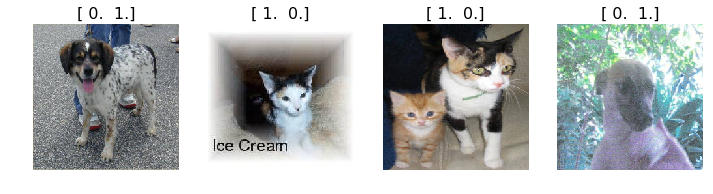

In [22]:
batch_size = 4

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [24]:
def pred_batch(imgs):
    preds = vgg.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))
        


TypeError: Error when checking : data should be a Numpy array, or list/dict of Numpy arrays. Found: <keras.preprocessing.image.DirectoryIterator object at 0x7efccce02b90>...